In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 

**In this notebook we are trying to show it's possible to automatically categorize product based on images**

* We will first use SIFT/ORB/SURF type algorythm

## Here is the steps we will take

- **Create descriptors for each image**: This involves extracting features or "descriptors" from each image. These could be simple features like color histograms, or more complex features like SIFT (Scale-Invariant Feature Transform) or SURF (Speeded Up Robust Features) descriptors. These descriptors capture important visual characteristics of the images.
   - To get better desciptor preprocessing of the picture can be applied





- **Create clusters of descriptors**: Once you have extracted descriptors from all the images, you can cluster these descriptors. This involves grouping together descriptors that are similar to each other. Each cluster represents a particular visual "theme" that occurs in the images. Usually nCategory*10 < nClusers > sqrt(nDescriptor)

- **Create image features**
   * For each image:
      - **Predict the cluster number for each descriptor**: This involves assigning each descriptor in the image to one of the clusters created in the previous step. This gives an idea of which visual "themes" are present in each image. 
      - **Create a histogram**: This involves counting the number of descriptors in the image that belong to each cluster. The histogram serves as a compact summary of the visual content of the image.



- **PCA and t-SNE reduction**: This involves reducing the dimensionality of the image histograms using PCA (Principal Component Analysis) and t-SNE (t-Distributed Stochastic Neighbor Embedding). To make it easier to visualize the data and can also speed up subsequent analysis.

- **Clustering of t-SNE and ARI to verify feasibility**: This involves applying a clustering algorithm (K-means) to the low-dimensional t-SNE representation of the data. Then calculate the Adjusted Rand Index (ARI) to measure the similarity between the resulting clusters and the true categories of the images. This gives an idea of how well the visual content of the images aligns with the categories.

In [2]:
image_categ = pd.read_csv('U://DATA/OpenClassrooms/Data science/P6/Flipkart/image_data.csv')

path = 'U://DATA/OpenClassrooms/Data science/P6/Flipkart/Images/'
list_photos = [cv2.imread(path + img) for img in image_categ['image_name']]
print(len(list_photos))

1050


# Pre Processing

In [3]:
def preprocess_images(image_list, size=(256, 256)):
    # Initialize an empty list to store the preprocessed images
    preprocessed_images = []

    # Loop over all images in the list
    for i, img in enumerate(image_list):
         # Resize the image
        img1 = cv2.resize(img, size)

        # Convert the image to grayscale
        gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

        # Apply histogram equalization
        equalized = cv2.equalizeHist(gray)

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(equalized, (5, 5), 0)

        # Append the preprocessed image to the list
        preprocessed_images.append(blurred)

        # If this is one of the first 3 images, display the before and after
        if i < 1:
           fig, axs = plt.subplots(2, 2, figsize=(12, 12))
           axs[0, 0].imshow(img, cmap='gray')
           axs[0, 0].set_title('Original Image')
           axs[0, 1].imshow(blurred, cmap='gray')
           axs[0, 1].set_title('Preprocessed Image')
           axs[1, 0].hist(img.ravel(), bins=256, color='gray')
           axs[1, 0].set_title('Histogram of Original Image')
           axs[1, 1].hist(blurred.ravel(), bins=256, color='gray')
           axs[1, 1].set_title('Histogram of Preprocessed Image')
           plt.show()

    return preprocessed_images

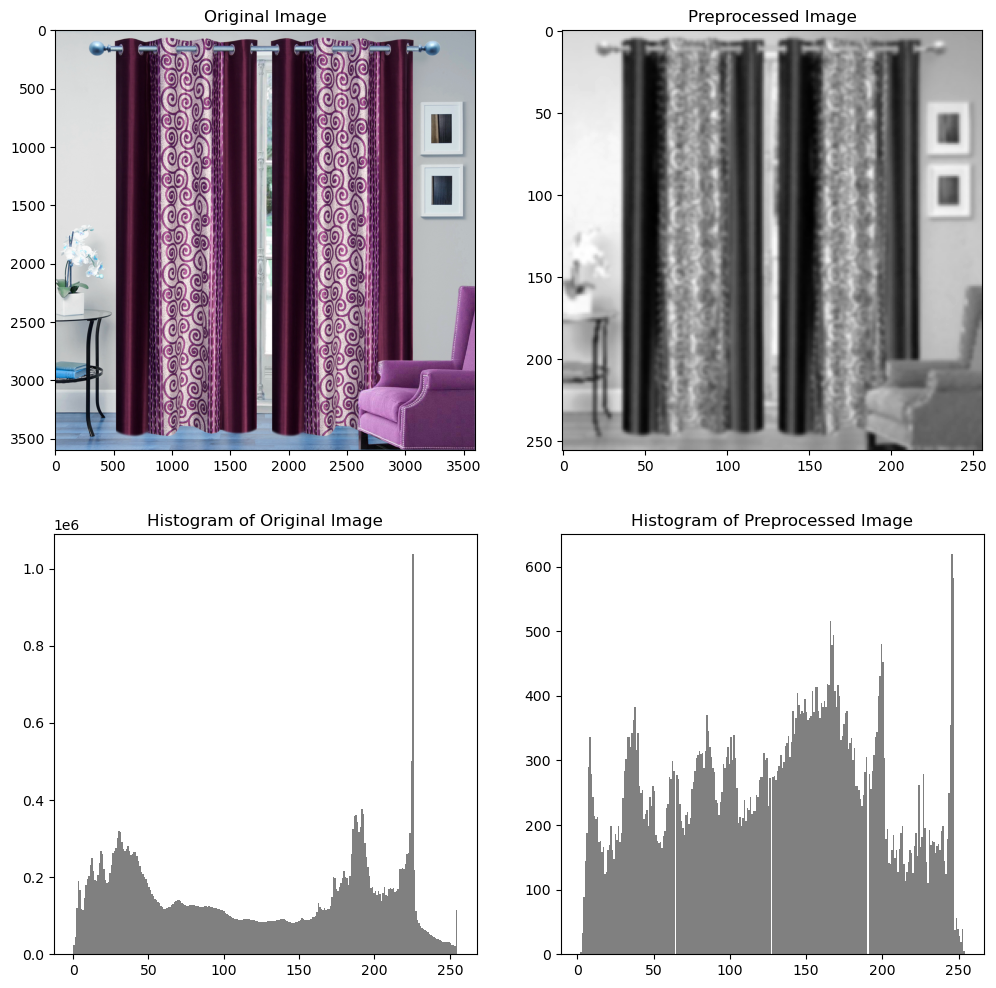

In [4]:
preprocessed_images = preprocess_images(list_photos)

In [11]:
len(preprocessed_images)

1050

# Descriptor Creation

In [18]:
def apply_sift(image_list):
    # Initialize SIFT
    sift = cv2.xfeatures2d.SIFT_create(500)

    # Initialize an empty list to store the keypoints and descriptors
    descriptors = []

    # Loop over all images in the list
    for i, img in enumerate(image_list):
        # Apply SIFT to the image
        kp, des = sift.detectAndCompute(img, None)
        print(f"Descriptor shape for image {i+1}: {des.shape}")
        # Append the keypoints and descriptors to the list
        descriptors.append(des)

        # If this is the first image, display the keypoints
        if i < 3:
            img_with_keypoints = cv2.drawKeypoints(img, kp, img)
            plt.imshow(img_with_keypoints)
            plt.show()

    
    return descriptors

Descriptor shape for image 1: (500, 128)


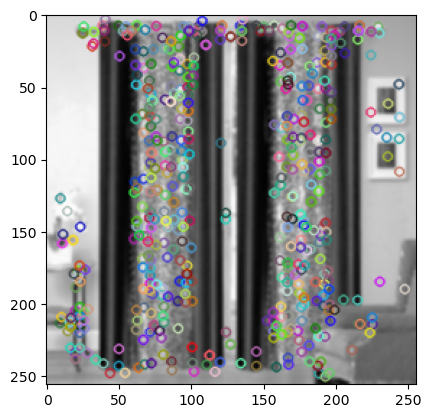

Descriptor shape for image 2: (489, 128)


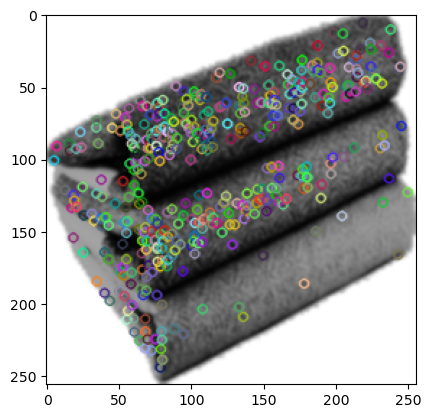

Descriptor shape for image 3: (500, 128)


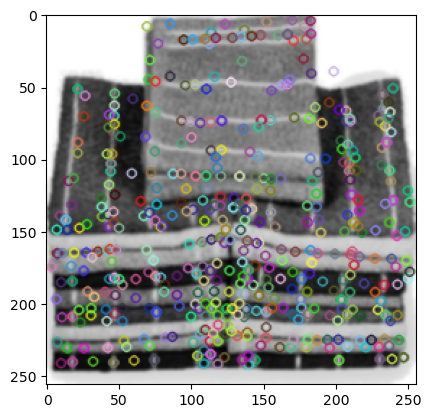

Descriptor shape for image 4: (500, 128)
Descriptor shape for image 5: (500, 128)
Descriptor shape for image 6: (501, 128)
Descriptor shape for image 7: (350, 128)
Descriptor shape for image 8: (280, 128)
Descriptor shape for image 9: (314, 128)
Descriptor shape for image 10: (395, 128)
Descriptor shape for image 11: (230, 128)
Descriptor shape for image 12: (455, 128)
Descriptor shape for image 13: (327, 128)
Descriptor shape for image 14: (269, 128)
Descriptor shape for image 15: (169, 128)
Descriptor shape for image 16: (174, 128)
Descriptor shape for image 17: (65, 128)
Descriptor shape for image 18: (293, 128)
Descriptor shape for image 19: (339, 128)
Descriptor shape for image 20: (201, 128)
Descriptor shape for image 21: (501, 128)
Descriptor shape for image 22: (292, 128)
Descriptor shape for image 23: (287, 128)
Descriptor shape for image 24: (348, 128)
Descriptor shape for image 25: (328, 128)
Descriptor shape for image 26: (269, 128)
Descriptor shape for image 27: (501, 128)

In [19]:
descriptors = apply_sift(preprocessed_images) #a list of arrays where each array contains the descriptors for a single image

In [20]:
all_descriptors = np.concatenate(descriptors, axis=0) #a single array that contains the descriptors for all images.
all_descriptors.shape

(325326, 128)

# Create Clusters of Descriptors

In [21]:
from sklearn import cluster, metrics

# Determination number of clusters
k = int(round(np.sqrt(len(all_descriptors)),0))
print("Estimated number of clusters: ", k)

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(all_descriptors)


Estimated number of clusters:  570


c:\ProgramData\Anaconda3\envs\Tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\Anaconda3\envs\Tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 5120 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


MiniBatchKMeans(init_size=1710, n_clusters=570, random_state=0)

We now have a model that can split the descriptors in 570 different clusters.

**The features of our images is going to be how many descriptors they have in each of those clusters.**

We call those features histograms

# Create Features


In [22]:
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des # normalizing the hist so the sum is 1, helps with images that have different nb of descriptors
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(descriptors) :  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

img_features = np.asarray(hist_vectors)

# Dimension Reduction

**PCA and T-SNE**
- PCA first because T-SNE is more performant with less dimensions 
- T-SNE because we need a 2d representation of our data (PC1 and PC2 would not be representative of our data)

In [23]:
from sklearn import manifold, decomposition

print("Dimensions before PCA : ", img_features.shape)
pca = decomposition.PCA(n_components=0.80) #Keep as much variance as possible while reducing the dimensions 
feat_pca= pca.fit_transform(img_features)
print("Dimensions after PCA : ", feat_pca.shape)

Dimensions before PCA :  (1050, 570)
Dimensions after PCA :  (1050, 124)


In [24]:
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = image_categ['category']
print(df_tsne.shape)

(1050, 3)


# Visualization

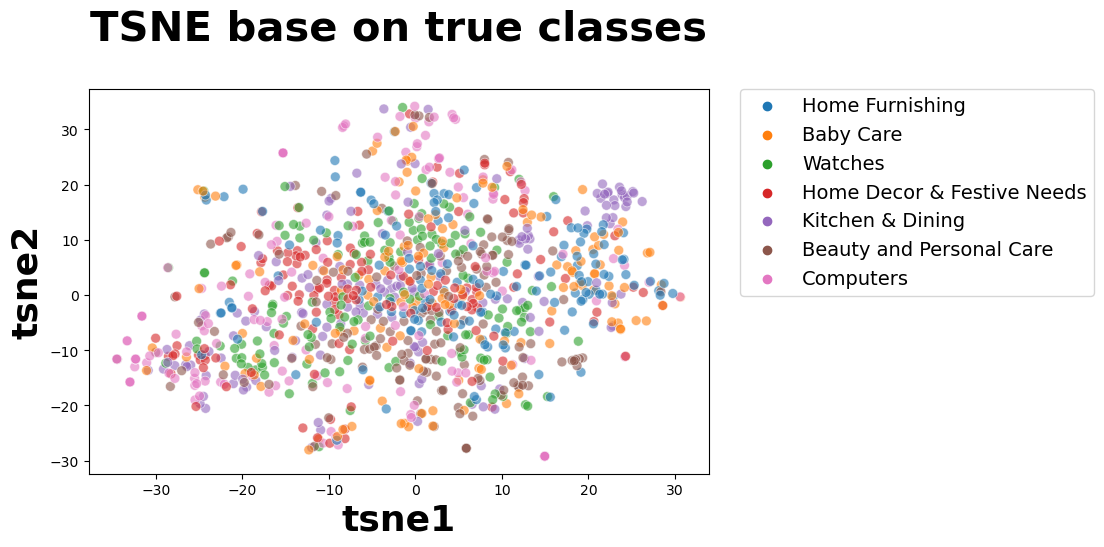

In [25]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE base on true classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

Let's look at what the clustering of T-SNE1 and 2 would look like

In [26]:
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

c:\ProgramData\Anaconda3\envs\Tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\Anaconda3\envs\Tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


(1050, 4)


In [27]:
df_tsne

,tsne1,tsne2,class,cluster
0,8.363858,-9.419550,Home Furnishing,5
1,20.613720,0.901025,Baby Care,3
2,10.539410,-19.675547,Baby Care,5
3,20.881029,0.833851,Home Furnishing,3
4,22.844603,-0.364152,Home Furnishing,3
...,...,...,...,...
1045,-8.996424,-25.618559,Baby Care,1
1046,8.872915,19.500706,Baby Care,0
1047,-8.361888,-24.376671,Baby Care,1
1048,3.122139,9.757584,Baby Care,6


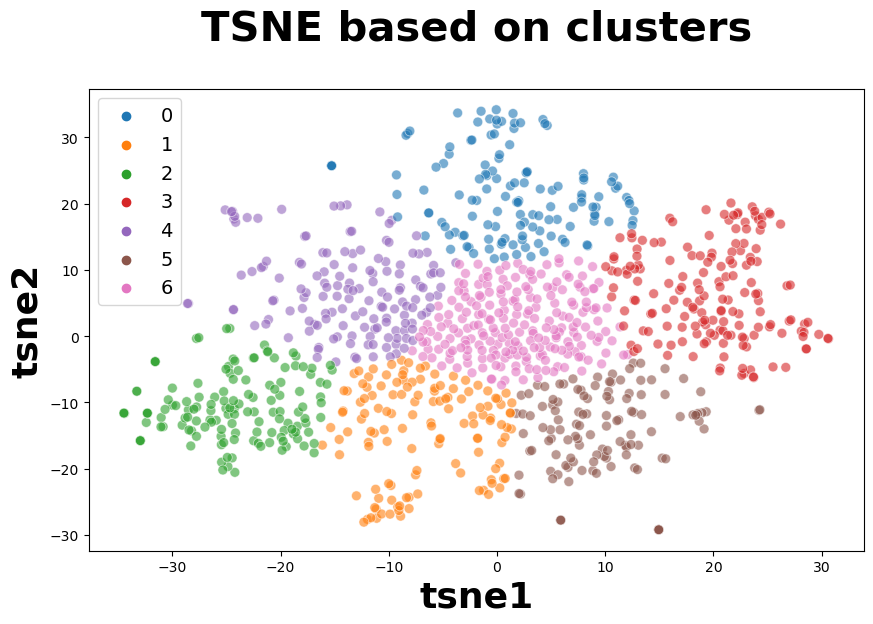

ARI :  0.04332486145537633


In [28]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE based on clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

print("ARI : ", metrics.adjusted_rand_score(df_tsne['class'], df_tsne["cluster"]))

**The ARI comfirm the graph, showing few signs of correct clusstering**

# Conclusion

- We can see it is possible to automaticaly categorize pictures
- SIFT is not getting us good results

We need another way to get features for our images, let's look into CNN !!

----------------------------
----------------------------

In [29]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.models import Model, Sequential

**VGG16 is a convolutional neural network (CNN)**

It's a 16-layer deep neural network with 138million parameters that has been trained for the classification of ImageNet (14millions pic dataset) into a 1000 category

Reaching a 92.7% accuracy we know it's really good at generating features that can then be sorted into a 1000different clusters or categories


# Transfer learning

Training our own model from scratch would be difficult, so we want to use a model that's already been trained.

We are not intrested in getting which one of the 1000 categories our picture would be put in. **We only need to class them into 7 different categories.**

So we're going to use VGG16 as a feature generator.

## VGG16 Architecture
**Let's pay attention mainly to the last 4 layers:**

- FC1 : fully connected layer with 4096 channels
- FC2 : fully connected layer with 4096 channels
- FC3 : fully connected layer with 1000 channels 
    - that's where the classification into the 1000 categories happen
- Softmap : for multiclass classification, producing a probability distribution over the classes

**So if we `remove the last two layers` and input a picture we will get 4096 features as an output**

For now let's use those features in the same way as we used the SIFT features. 
- PCA then T-SNE 
- Kmeans on the T-SNE and ARI with the true classes

**That way we can verify if it's possible to use VGG16 as features and how good it's looking for automaticaly categorize our pictures**

In [30]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [31]:
image_path = [path + img for img in image_categ['image_name']]

In [32]:
images_features = []
i=0 
for image_file in image_path :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600


c:\ProgramData\Anaconda3\envs\Tensorflow\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000


(1050, 4096)

In [40]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


In [41]:
from sklearn import manifold, decomposition


tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)


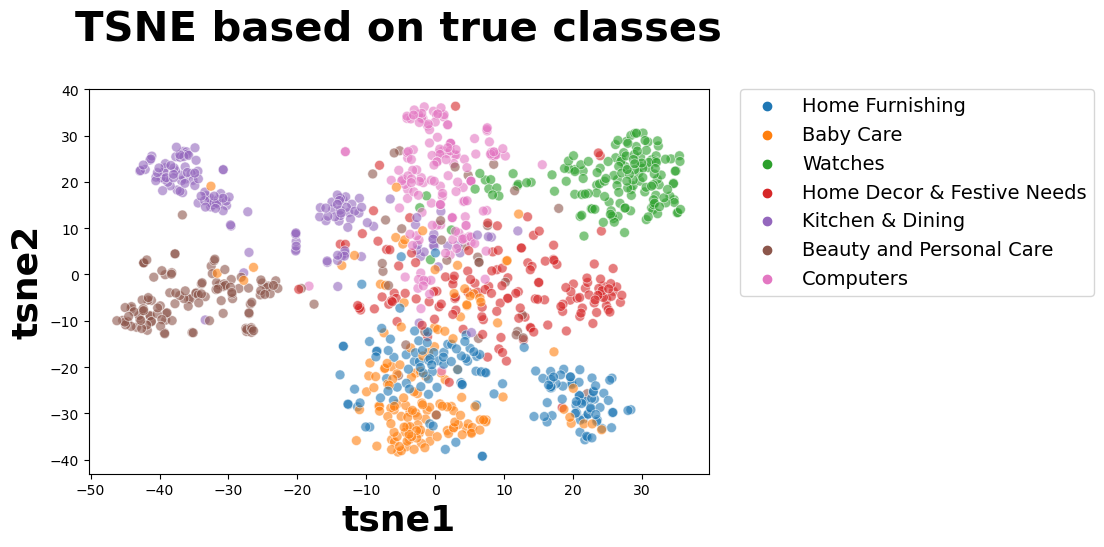

In [42]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = image_categ['category']

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE based on true classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 
plt.legend(prop={'size': 14}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [43]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

c:\ProgramData\Anaconda3\envs\Tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


KMeans(n_clusters=7, n_init=100)

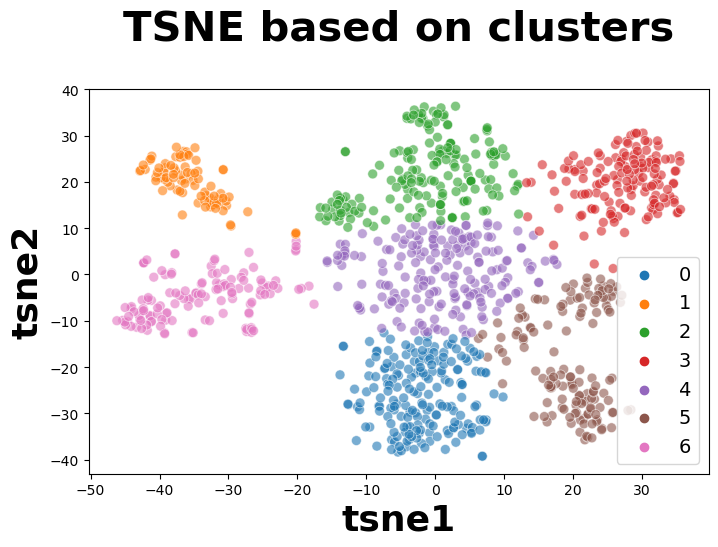

ARI :  0.4552818177319452


In [44]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE based on clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = image_categ['category']
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

# Conclusion

- the ARI is much higher and we can see clear sign of clustering in our graphs
- Automatically categorizing our pictures seems possible


**Next step:**
* Let's train our own last layer for the VGG16 model that will output 7 channels